# VGG16 for Image classification tasks template

In [2]:
# Configure matlab to show graphics in the notebook
%matplotlib inline

In [3]:
# Import the VGG16 architecture; see https://keras.io/applications/#vgg16
from keras.applications.vgg16 import VGG16

Using Theano backend.


In [4]:
model = VGG16()

In [5]:
# Increase the number of epochs and the batch size when training on GPU
BATCH_SIZE = 16
EPOCHS = 1

# Path to the images directory. The directory must have a directory for every class, for example:
# /train/dogs/
# /train/cats/
# It is a good idea to have a directory with a very small sample, to check quickly that everything is OK before
# switching to expensive GPUs
PATH = 'data/dogscats/sample/'
# Uncomment on GPU:
#PATH = 'data/dogscats/'
PATH_TRAIN = PATH + 'train/'
PATH_VALIDATION = PATH + 'valid/'

In [6]:
# Prepare image generators
from keras.preprocessing import image

def get_train_generator(batch_size=BATCH_SIZE):
    return image.ImageDataGenerator().flow_from_directory(
                        PATH_TRAIN, 
                        target_size=(224,224), 
                        class_mode='categorical', 
                        shuffle=True,
                        batch_size=batch_size)

def get_validation_generator(batch_size=BATCH_SIZE):
    return image.ImageDataGenerator().flow_from_directory(
                        PATH_VALIDATION, 
                        target_size=(224,224), 
                        class_mode='categorical', 
                        shuffle=True,
                        batch_size=batch_size)
# VGG expects images of size 224x224. By setting the target size, Keras automatically resizes all images to
# the given size


In [7]:
# Utility function that wraps model compilation
from keras.optimizers import Adam
def compile(lr=0.001):
    model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy', metrics=['accuracy'])

Found 16 images belonging to 2 classes.


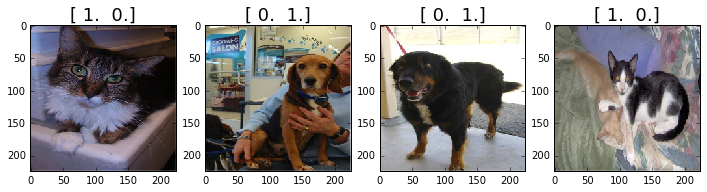

In [8]:
# Visualize some images
import numpy as np
import matplotlib.pyplot as plt
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

NUMBER_OF_IMAGES_TO_SHOW = 4
images, labels = next(get_train_generator(NUMBER_OF_IMAGES_TO_SHOW))
plots(images, titles=labels)

In [9]:
def normalize(probs):
    prob_factor = 1 / sum(probs)
    return [round(prob_factor * p, 2) for p in probs]

In [10]:
# A function that by given batches from generator, removes the top layer and replaces it
# with a fully connected layer with the new number of classes
# The main idea is that we are using the features extracted by the convolutions
from keras.layers.core import Dense
from keras.engine.training import Model
def finetune(batches):
    global model
    model.layers.pop()
    new_layer = Dense(batches.nb_class, activation='softmax', name='new_layer')
    inp = model.input
    out = new_layer(model.layers[-1].output)
    model = Model(inp, out)
    for layer in model.layers:
        if layer is not new_layer:
            layer.trainable=False
    compile()

In [11]:
print "Ouput classes before finetuning: {}".format(model.layers[-1].output_dim)

Ouput classes before finetuning: 1000


In [12]:
finetune(get_train_generator())

Found 16 images belonging to 2 classes.


In [13]:
print "Ouput classes after finetuning: {}".format(model.layers[-1].output_dim)

Ouput classes after finetuning: 2


In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 224)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 224)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 112, 112)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [27]:
batches = get_train_generator()
val_batches = get_validation_generator()
import time
start = time.time()
history = model.fit_generator(batches, 
                    samples_per_epoch=batches.nb_sample, 
                    nb_epoch=EPOCHS,
                    validation_data=val_batches, 
                    nb_val_samples=val_batches.nb_sample)
elapsed = time.time() - start
print "Overall time: {}".format(elapsed)
print "Average per epoch: {}".format(elapsed/float(EPOCHS))

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/1
16/16 [==============================] - 34s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.2595 - val_acc: 0.8750
Overall time: 34.5807080269
Average per epoch: 34.5807080269


In [21]:
predictions = map(lambda x: [round(x[0], 3), round(x[1], 3)], model.predict(images))

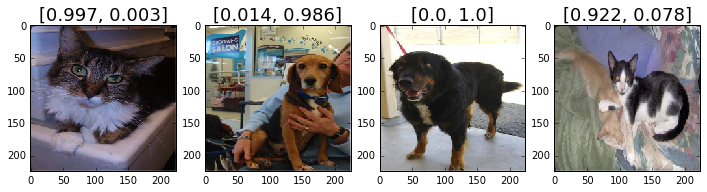

In [24]:
plots(images, titles=predictions)